<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Тема 6. Задача восстановления регрессии</center>
## <center>Практика. Линейная регрессия</center>
<center>*Материал тот же, что в специализации "Машинное обучение и анализ данных" (и автор тот же), поэтому распространяется без решения.*

### Часть 1. Первичный анализ данных c Pandas

В этом заданиии мы будем использовать данные [SOCR](http://wiki.stat.ucla.edu/socr/index.php/SOCR_Data_Dinov_020108_HeightsWeights) по росту и весу 25 тысяч подростков.

**[1]. Если у Вас не установлена библиотека Seaborn - выполните в терминале команду *conda install seaborn*. (Seaborn не входит в сборку Anaconda, но эта библиотека предоставляет удобную высокоуровневую функциональность для визуализации данных).**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [55]:
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize

Считаем данные по росту и весу (*weights_heights.csv*, приложенный в задании) в объект Pandas DataFrame:

In [2]:
data = pd.read_csv('../../data/weights_heights.csv', index_col='Index')

Чаще всего первое, что надо надо сделать после считывания данных - это посмотреть на первые несколько записей. Так можно отловить ошибки чтения данных (например, если вместо 10 столбцов получился один, в названии которого 9 точек с запятой). Также это позволяет познакомиться с данными, как минимум, посмотреть на признаки и их природу (количественный, категориальный и т.д.). 

После этого стоит построить гистограммы распределения признаков - это опять-таки позволяет понять природу признака (степенное у него распределение, или нормальное, или какое-то еще). Также благодаря гистограмме можно найти какие-то значения, сильно не похожие на другие - "выбросы" в данных. 
Гистограммы удобно строить методом *plot* Pandas DataFrame с аргументом *kind='hist'*.

**Пример.** Построим гистограмму распределения роста подростков из выборки *data*. Используем метод *plot* для DataFrame *data* c аргументами *y='Height'* (это тот признак, распределение которого мы строим)

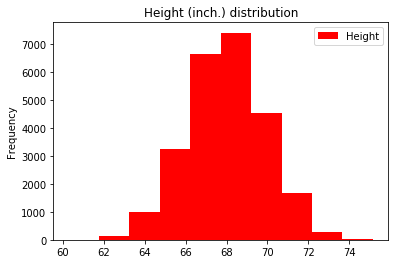

In [3]:
data.plot(y='Height', kind='hist', 
           color='red',  title='Height (inch.) distribution');

Аргументы:

- *y='Height'* - тот признак, распределение которого мы строим
- *kind='hist'* - означает, что строится гистограмма
- *color='red'* - цвет

**[2]. Посмотрите на первые 5 записей с помощью метода *head* Pandas DataFrame. Нарисуйте гистограмму распределения веса с помощью метода *plot* Pandas DataFrame. Сделайте гистограмму зеленой, подпишите картинку.**

In [4]:
# Ваш код здесь
data.head()

,Height,Weight
Index,,
1,65.78331,112.9925
2,71.51521,136.4873
3,69.39874,153.0269
4,68.21660,142.3354
5,67.78781,144.2971


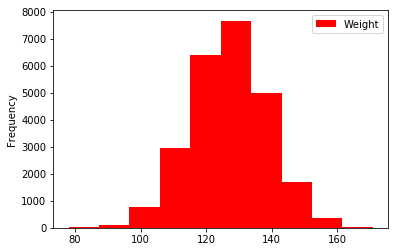

In [5]:
# Ваш код здесь
data.plot(y='Weight', color='red', kind='hist')

Один из эффективных методов первичного анализа данных - отображение попарных зависимостей признаков. Создается $m \times m$ графиков (*m* - число признаков), где по диагонали рисуются гистограммы распределения признаков, а вне диагонали - scatter plots зависимости двух признаков. Это можно делать с помощью метода $scatter\_matrix$ Pandas Data Frame или *pairplot* библиотеки Seaborn. 

Чтобы проиллюстрировать этот метод, интересней добавить третий признак. Создадим признак *Индекс массы тела* ([BMI](https://en.wikipedia.org/wiki/Body_mass_index)). Для этого воспользуемся удобной связкой метода *apply* Pandas DataFrame и lambda-функций Python.

In [6]:
def make_bmi(height_inch, weight_pound):
    METER_TO_INCH, KILO_TO_POUND = 39.37, 2.20462
    return (weight_pound / KILO_TO_POUND) / \
           (height_inch / METER_TO_INCH) ** 2

In [7]:
data['BMI'] = data.apply(lambda row: make_bmi(row['Height'], 
                                              row['Weight']), axis=1)

In [8]:
data.head()

,Height,Weight,BMI
Index,,,
1,65.78331,112.9925,18.357573
2,71.51521,136.4873,18.762577
3,69.39874,153.0269,22.338895
4,68.21660,142.3354,21.504526
5,67.78781,144.2971,22.077581


**[3]. Постройте картинку, на которой будут отображены попарные зависимости признаков , 'Height', 'Weight' и 'BMI' друг от друга. Используйте метод *pairplot* библиотеки Seaborn.**

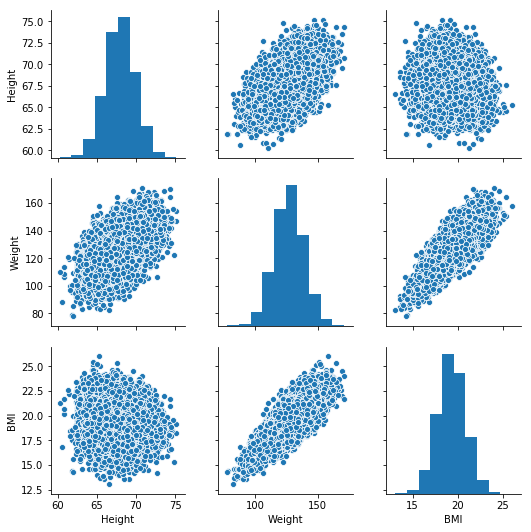

In [9]:
# Ваш код здесь
sns.pairplot(data)

Часто при первичном анализе данных надо исследовать зависимость какого-то количественного признака от категориального (скажем, зарплаты от пола сотрудника). В этом помогут "ящики с усами" - boxplots библиотеки Seaborn. Box plot - это компактный способ показать статистики вещественного признака (среднее и квартили) по разным значениям категориального признака. Также помогает отслеживать "выбросы" - наблюдения, в которых значение данного вещественного признака сильно отличается от других. 

**[4]. Создайте в DataFrame *data* новый признак *weight_category*, который будет иметь 3 значения: 1 – если вес меньше 120 фунтов. (~ 54 кг.), 3 - если вес  больше или равен 150 фунтов (~68 кг.), 2 – в остальных случаях. Постройте «ящик с усами» (boxplot), демонстрирующий зависимость роста от весовой категории. Используйте метод *boxplot* библиотеки Seaborn и метод *apply* Pandas DataFrame. Подпишите ось *y* меткой «Рост», ось *x* – меткой «Весовая категория».**

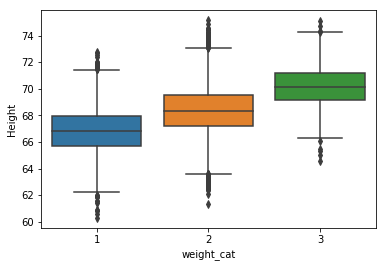

In [10]:
def weight_category(weight):
    return 1 if weight < 120 else 2 if weight <= 150 else 3
    # Ваш код здесь

data['weight_cat'] = data['Weight'].apply(weight_category)
# Ваш код здесь
sns.boxplot(x=data['weight_cat'], y=data['Height'])

**[5]. Постройте scatter plot зависимости роста от веса, используя метод *plot* для Pandas DataFrame с аргументом *kind='scatter'*. Подпишите картинку.**

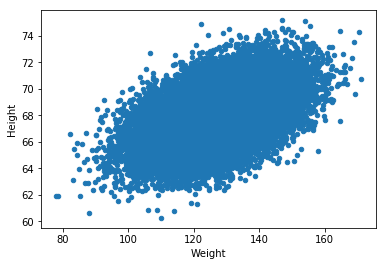

In [11]:
# Ваш код здесь
data.plot(kind='scatter', x='Weight', y='Height')

## Часть 2. Минимизация квадратичной ошибки

В простейшей постановке задача прогноза значения вещественного признака по прочим признакам (задача восстановления регрессии) решается минимизацией квадратичной функции ошибки. 

**[6]. Напишите функцию, которая по двум параметрам $w_0$ и $w_1$ вычисляет квадратичную ошибку приближения зависимости роста $y$ от веса $x$ прямой линией $y = w_0 + w_1 * x$:**
$$error(w_0, w_1) = \sum_{i=1}^n {(y_i - (w_0 + w_1 * x_i))}^2 $$
Здесь $n$ – число наблюдений в наборе данных, $y_i$ и $x_i$ – рост и вес $i$-ого человека в наборе данных. 

In [20]:
# Ваш код здесь
def mse(x, y, w0, w1):
    y_pred = w0 + w1 * x
    return np.sum(np.square(y - y_pred))

Итак, мы решаем задачу: как через облако точек, соответсвующих наблюдениям в нашем наборе данных, в пространстве признаков "Рост" и "Вес" провести прямую линию так, чтобы минимизировать функционал из п. 6. Для начала давайте отобразим хоть какие-то прямые и убедимся, что они плохо передают зависимость роста от веса.

**[7]. Проведите на графике из п. 5 Задания 1 две прямые, соответствующие значениям параметров ($w_0, w_1) = (60, 0.05)$ и ($w_0, w_1) = (50, 0.16)$. Используйте метод *plot* из *matplotlib.pyplot*, а также метод *linspace* библиотеки NumPy. Подпишите оси и график.**

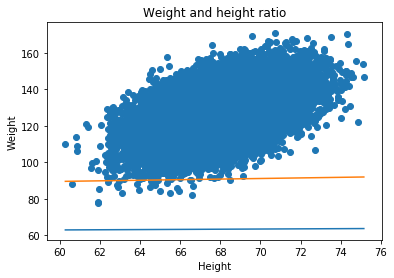

In [13]:
# Ваш код здесь
x = np.linspace(min(data['Height']), max(data['Height']))
y1 = .05 * x + 60
y2 = .16 * x + 80
plt.plot(x, y1)
plt.plot(x, y2)
plt.scatter(x=data['Height'], y=data['Weight'])
plt.title('Weight and height ratio')
plt.xlabel('Height')
plt.ylabel('Weight')
plt.show()

Минимизация квадратичной функции ошибки - относительная простая задача, поскольку функция выпуклая. Для такой задачи существует много методов оптимизации. Посмотрим, как функция ошибки зависит от одного параметра (наклон прямой), если второй параметр (свободный член) зафиксировать.

**[8]. Постройте график зависимости функции ошибки, посчитанной в п. 6, от параметра $w_1$ при $w_0$ = 50. Подпишите оси и график.**

2901844.559012083

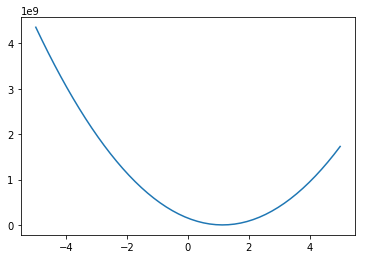

In [14]:
# Ваш код здесь
values = np.linspace(-5, 5)
errors = [mse(data['Height'], data['Weight'], 50, i) for i in values]
plt.plot(values, errors)
min(errors)

Теперь методом оптимизации найдем "оптимальный" наклон прямой, приближающей зависимость роста от веса, при фиксированном коэффициенте $w_0 = 50$.

** [9]. С помощью метода *minimize_scalar* из *scipy.optimize* найдите минимум функции, определенной в п. 6, для значений параметра  $w_1$ в диапазоне [-5,5]. Проведите на графике из п. 5 Задания 1 прямую, соответствующую значениям параметров ($w_0$, $w_1$) = (50, $w_1\_opt$), где $w_1\_opt$ – найденное в п. 8 оптимальное значение параметра $w_1$. **

In [28]:
# Ваш код здесь
res = minimize_scalar(mse, bounds=(-5, 5), method='bounded', args=(data['Height'], data['Weight'], 50))
res.x

-1.18172615112

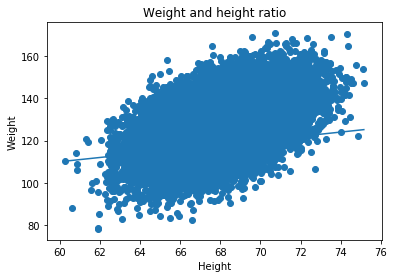

In [31]:
# Ваш код здесь
w0, w1 = 50, 1
x = np.linspace(min(data['Height']), max(data['Height']))
y = w1 * x + w0
plt.plot(x, y)
plt.scatter(x=data['Height'], y=data['Weight'])
plt.title('Weight and height ratio')
plt.xlabel('Height')
plt.ylabel('Weight')
plt.show()

При анализе многомерных данных человек часто хочет получить интуитивное представление о природе данных с помощью визуализации. Увы, при числе признаков больше 3 такие картинки нарисовать невозможно. На практике для визуализации данных в 2D и 3D в данных выделаяют 2 или, соответственно, 3 главные компоненты (как именно это делается - мы увидим далее в курсе) и отображают данные на плоскости или в объеме. 

Посмотрим, как в Python рисовать 3D картинки, на примере отображения функции $z(x,y) = sin(\sqrt{x^2+y^2})$ для значений $x$ и $y$ из интервала [-5,5] c шагом 0.25.

In [33]:
from mpl_toolkits.mplot3d import Axes3D

Создаем объекты типа matplotlib.figure.Figure (рисунок) и  matplotlib.axes._subplots.Axes3DSubplot (ось). 

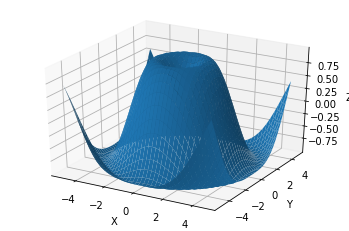

In [53]:
fig = plt.figure()
ax = fig.gca(projection='3d') # get current axis

# Создаем массивы NumPy с координатами точек по осям X и У. 
# Используем метод meshgrid, при котором по векторам координат 
# создается матрица координат. Задаем нужную функцию Z(x, y).
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
Z = np.sin(np.sqrt(X**2 + Y**2))

# Наконец, используем метод *plot_surface* объекта 
# типа Axes3DSubplot. Также подписываем оси.
surf = ax.plot_surface(X, Y, Z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

**[10]. Постройте 3D-график зависимости функции ошибки, посчитанной в п.6 от параметров $w_0$ и $w_1$. Подпишите ось $x$ меткой «Intercept», ось $y$ – меткой «Slope», a ось $z$ – меткой «Error».**

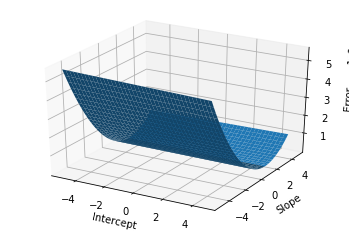

In [52]:
# Ваш код здесь
fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)

Z = []
for w0, w1 in zip(X.flatten(), Y.flatten()):
    Z.append(mse(data['Height'], data['Weight'], w0, w1))
    
Z = np.array(Z).reshape(X.shape)

surf = ax.plot_surface(X, Y, Z)
ax.set_xlabel('Intercept')
ax.set_ylabel('Slope')
ax.set_zlabel('Error')
plt.show()

**[11]. С помощью метода *minimize* из scipy.optimize найдите минимум функции, определенной в п. 6, для значений параметра $w_0$ в диапазоне [-100,100] и $w_1$ - в диапазоне [-5, 5]. Начальная точка – ($w_0$, $w_1$) = (0, 0). Используйте метод оптимизации L-BFGS-B (аргумент method метода minimize). Проведите на графике из п. 5 Задания 1 прямую, соответствующую найденным оптимальным значениям параметров $w_0$ и $w_1$. Подпишите оси и график.**

In [62]:
def mse_(x, y, weights):
    print(weights)
    w0, w1 = weights
    y_pred = w0 + w1 * x
    return np.sum(np.square(y - y_pred))

In [64]:
# Ваш код здесь
res = minimize(mse_, (0, 0), bounds=((-100, 100), (-5, 5)),
               method='L-BFGS-B', args=(data['Height'], data['Weight']))
res.x

Index
1        112.99250
2        136.48730
3        153.02690
4        142.33540
5        144.29710
6        123.30240
7        141.49470
8        136.46230
9        112.37230
10       120.66720
11       127.45160
12       114.14300
13       125.61070
14       122.46180
15       116.08660
16       139.99750
17       129.50230
18       142.97330
19       137.90250
20       124.04490
21       141.28070
22       143.53920
23        97.90191
24       129.50270
25       141.85010
26       129.72440
27       142.42350
28       131.55020
29       108.33240
30       113.89220
           ...    
24971    126.61020
24972    122.98440
24973    123.28490
24974    125.59280
24975    123.71280
24976    123.24460
24977    115.41800
24978    108.71780
24979    141.58230
24980    120.88630
24981    154.43990
24982    107.39010
24983    118.72070
24984    111.49110
24985    127.72140
24986    133.91260
24987    120.81760
24988    142.84940
24989    103.38100
24990    141.23700
24991    125.36720
24992 

ValueError: too many values to unpack (expected 2)

In [22]:
# Ваш код здесь